# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

New York City (NYC), often called The City or simply New York (NY), is the most populous city in the United States. With an estimated 2019 population of 8,336,817 distributed over about 302.6 square miles (784 km2), New York is also the most densely populated major city in the United States.[6] Located at the southern tip of the U.S. state of New York, the city is the center of the New York metropolitan area, the largest metropolitan area in the world by urban landmass.[10] With almost 20 million people in its metropolitan statistical area and approximately 23 million in its combined statistical area, it is one of the world's most populous megacities. New York City has been described as the cultural, financial, and media capital of the world, significantly influencing commerce,[11] entertainment, research, technology, education, politics, tourism, art, fashion, and sports. Home to the headquarters of the United Nations,[12] New York is an important center for international diplomacy. 
It's hard to find the right cuisine for the new restaurant if you want to open new or add a new cuisine to your restaurant menu. It can be influenced by geographical area, popular foods types and number of restaurants serving them. There are many businesses shutting down because they couldn’t find the right item(cuisines) that can pique the interest of the customers. If you couldn't find the right cuisine for your restaurant it can cause to shutting down your business. So, it's always important to choose the right cuisine for your restaurant so, you can make profit. 

## Data <a name="data"></a>

a) a dataset that contains the boroughs and the neighborhoods that exist in each borough as well as the latitude and longitude coordinates of each neighborhood https://cocl.us/new_york_dataset 

b) Utilizing Foursquare API to explore the neighborhoods venues that contain cuisine of restaurant 

## Methodology <a name="methodology"></a>

Importing libaries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         395 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

## 1. Download and Explore Dataset

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 


In [2]:
#!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [3]:
ny_data = neighborhoods.reset_index(drop=True)
ny_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

# MAp of NYC

In [5]:
latitude=40.7127281
longitude=-74.0060152

map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork


#### Define Foursquare Credentials and Version

In [6]:
CLIENT_ID = 'WOM5KMQY1MOD04ORIGUWBUS2VZ0IGPIWU054YZZA0O1RD2ZM' # your Foursquare ID
CLIENT_SECRET = 'MBFUEITCWWGLW1IIDBYE1KLGRUZ1OHCPXUOQ42Y3KZB0HUXT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WOM5KMQY1MOD04ORIGUWBUS2VZ0IGPIWU054YZZA0O1RD2ZM
CLIENT_SECRET:MBFUEITCWWGLW1IIDBYE1KLGRUZ1OHCPXUOQ42Y3KZB0HUXT


In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
LIMIT=100
ny_venues = getNearbyVenues(names=ny_data['Neighborhood'],
                                   latitudes=ny_data['Latitude'],
                                   longitudes=ny_data['Longitude']
                                  )


Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

KeyError: 'groups'

In [16]:
ny_venues = pd.read_csv("sample (1).csv") 
ny_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude          Venue  \
0  Marble Hill              40.876551               -73.91066       Arturo's   
1  Marble Hill              40.876551               -73.91066    Bikram Yoga   
2  Marble Hill              40.876551               -73.91066  Tibbett Diner   
3  Marble Hill              40.876551               -73.91066      Starbucks   
4  Marble Hill              40.876551               -73.91066        Dunkin'   

   Venue Latitude  Venue Longitude Venue Category  
0       40.874412       -73.910271    Pizza Place  
1       40.876844       -73.906204    Yoga Studio  
2       40.880404       -73.908937          Diner  
3       40.877531       -73.905582    Coffee Shop  
4       40.877136       -73.906666     Donut Shop

Now lets analyze neighborhood

In [17]:
ny_venues.sort_values(['Venue','Venue Category'])

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
245                Inwood              40.867684              -73.921210   
2149   Financial District              40.707107              -74.010665   
2534        Midtown South              40.748510              -73.988713   
451           East Harlem              40.792249              -73.944182   
1840         West Village              40.734434              -74.006180   
1306              Chelsea              40.744035              -74.003116   
2641         Sutton Place              40.760280              -73.963556   
2462         Civic Center              40.715229              -74.005415   
148    Washington Heights              40.851903              -73.936900   
157    Washington Heights              40.851903              -73.936900   
135    Washington Heights              40.851903              -73.936900   
194    Washington Heights              40.851903              -73.936900   
1640         Little Italy              40.719324              -73.997305   
1748                 Soho              40.722184              -74.000657   
2174   Financial District              40.707107              -74.010665   
2581        Midtown South              40.748510              -73.988713   
2674         Sutton Place              40.760280              -73.963556   
2802           Tudor City              40.746917              -73.971219   
1166          Murray Hill              40.748303              -73.978332   
710            Lenox Hill              40.768113              -73.958860   
1546      Lower East Side              40.717807              -73.980890   
527       Upper East Side              40.775639              -73.960508   
1178          Murray Hill              40.748303              -73.978332   
1692         Little Italy              40.719324              -73.997305   
1736                 Soho              40.722184              -74.000657   
1887         West Village              40.734434              -74.006180   
2761           Turtle Bay              40.752042              -73.967708   
772      Roosevelt Island              40.762160              -73.949168   
2375                 Noho              40.723259              -73.988434   
678            Lenox Hill              40.768113              -73.958860   
1016              Clinton              40.759101              -73.996119   
974               Clinton              40.759101              -73.996119   
2966         Hudson Yards              40.756658              -74.000111   
992               Clinton              40.759101              -73.996119   
2978         Hudson Yards              40.756658              -74.000111   
898        Lincoln Square              40.773529              -73.985338   
2003             Gramercy              40.737210              -73.981376   
1539      Lower East Side              40.717807              -73.980890   
598             Yorkville              40.775930              -73.947118   
2501        Midtown South              40.748510              -73.988713   
404        Central Harlem              40.815976              -73.943211   
2068    Battery Park City              40.711932              -74.016869   
2071    Battery Park City              40.711932              -74.016869   
2183   Financial District              40.707107              -74.010665   
2074    Battery Park City              40.711932              -74.016869   
2142   Financial District              40.707107              -74.010665   
2224        Carnegie Hill              40.782683              -73.953256   
2229        Carnegie Hill              40.782683              -73.953256   
1038              Clinton              40.759101              -73.996119   
690            Lenox Hill              40.768113              -73.958860   
661            Lenox Hill              40.768113              -73.958860   
1558      Lower East Side              40.717807             

In [18]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0  Marble Hill                  0               0                  0   
1  Marble Hill                  0               0                  0   
2  Marble Hill                  0               0                  0   
3  Marble Hill                  0               0                  0   
4  Marble Hill                  0               0                  0   

   African Restaurant  American Restaurant  Antique Shop  Arcade  \
0                   0                    0             0       0   
1                   0                    0             0       0   
2                   0                    0             0       0   
3                   0                    0             0       0   
4                   0                    0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 0                       0            0           0   
2                 0                       0            0           0   
3                 0                       0            0           0   
4                 0                       0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auditorium  \
0                    0                 0                   0           0   
1                    0                 0                   0           0   
2                    0                 0                   0           0   
3                    0                 0                   0           0   
4                    0                 0                   0           0   

   Australian Restaurant  Austrian Restaurant  BBQ Joint  Baby Store  \
0                      0                    0          0           0   
1                      0                    0          0           0   
2                      0                    0          0           0   
3                      0                    0          0           0   
4                      0                    0          0           0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Basketball Court  \
0           0       0     0    0               0                 0   
1           0       0     0    0               0                 0   
2           0       0     0    0               0                 0   
3           0       0     0    0               0                 0   
4           0       0     0    0               0                 0   

   Basketball Stadium  Beer Bar  Beer Garden  Beer Store  \
0                   0         0            0           0   
1                   0         0            0           0   
2                   0         0            0           0   
3                   0         0            0           0   
4                   0         0            0           0   

   Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  Board Shop  \
0                         0          0           0       0           0   
1                         0          0           0       0           0   
2                         0          0           0       0           0   
3                         0          0           0       0           0   
4                         0          0           0       0           0   

   Boat or Ferry  Bookstore  Boutique  Boxing Gym  Brazilian Restaurant  \
0              0          0         0           0                     0   
1              0          0         0           0                     0   
2              0          0         0           0                     0   
3              0          0         0           0                     0   
4              0          0         0           0                     0   

   Breakfast Spot  Bridal Shop  Bridge  Bubble Tea Shop  Building  \
0               0            0       0                0         0   
1               0    

## Analysis <a name="analysis"></a>

Lets sets venues with restaurants.<br>
we don't need restaurants it does no give any meaning to table

In [19]:
col_list=list(ny_onehot.columns)
subs = 'Restaurant'
ny_Restaurant = [i for i in col_list if subs in i] 

In [20]:
ny_Restaurant.insert(0,'Neighborhood')
ny_Restaurant.remove('Restaurant')

In [21]:
ny_Restaurant

['Neighborhood',
 'Afghan Restaurant',
 'African Restaurant',
 'American Restaurant',
 'Arepa Restaurant',
 'Argentinian Restaurant',
 'Asian Restaurant',
 'Australian Restaurant',
 'Austrian Restaurant',
 'Brazilian Restaurant',
 'Cajun / Creole Restaurant',
 'Cambodian Restaurant',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Caucasian Restaurant',
 'Chinese Restaurant',
 'Cuban Restaurant',
 'Czech Restaurant',
 'Dim Sum Restaurant',
 'Dumpling Restaurant',
 'Eastern European Restaurant',
 'Egyptian Restaurant',
 'Empanada Restaurant',
 'English Restaurant',
 'Ethiopian Restaurant',
 'Falafel Restaurant',
 'Fast Food Restaurant',
 'Filipino Restaurant',
 'French Restaurant',
 'German Restaurant',
 'Greek Restaurant',
 'Hawaiian Restaurant',
 'Hotpot Restaurant',
 'Indian Restaurant',
 'Israeli Restaurant',
 'Italian Restaurant',
 'Japanese Curry Restaurant',
 'Japanese Restaurant',
 'Jewish Restaurant',
 'Korean Restaurant',
 'Kosher Restaurant',
 'Latin American Restaurant',

In [22]:
df_ny_Restaurant=ny_onehot[ny_Restaurant]
df_ny_Restaurant.head(50)

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0   Marble Hill                  0                   0                    0   
1   Marble Hill                  0                   0                    0   
2   Marble Hill                  0                   0                    0   
3   Marble Hill                  0                   0                    0   
4   Marble Hill                  0                   0                    0   
5   Marble Hill                  0                   0                    0   
6   Marble Hill                  0                   0                    0   
7   Marble Hill                  0                   0                    0   
8   Marble Hill                  0                   0                    0   
9   Marble Hill                  0                   0                    0   
10  Marble Hill                  0                   0                    0   
11  Marble Hill                  0                   0                    0   
12  Marble Hill                  0                   0                    0   
13  Marble Hill                  0                   0                    0   
14  Marble Hill                  0                   0                    1   
15  Marble Hill                  0                   0                    0   
16  Marble Hill                  0                   0                    0   
17  Marble Hill                  0                   0                    0   
18  Marble Hill                  0                   0                    0   
19  Marble Hill                  0                   0                    0   
20  Marble Hill                  0                   0                    0   
21  Marble Hill                  0                   0                    0   
22  Marble Hill                  0                   0                    0   
23  Marble Hill                  0                   0                    0   
24  Marble Hill                  0                   0                    0   
25  Marble Hill                  0                   0                    0   
26    Chinatown                  0                   0                    0   
27    Chinatown                  0                   0                    0   
28    Chinatown                  0                   0                    0   
29    Chinatown                  0                   0                    0   
30    Chinatown                  0                   0                    0   
31    Chinatown                  0                   0                    0   
32    Chinatown                  0                   0                    0   
33    Chinatown                  0                   0                    0   
34    Chinatown                  0                   0                    0   
35    Chinatown                  0                   0                    0   
36    Chinatown                  0                   0                    0   
37    Chinatown                  0                   0                    0   
38    Chinatown                  0                   0                    0   
39    Chinatown                  0                   0                    0   
40    Chinatown                  0                   0                    0   
41    Chinatown                  0                   0                    0   
42    Chinatown                  0                   0                    0   
43    Chinatown                  0                   0                    0   
44    Chinatown                  0                   0                    0   
45    Chinatown                  0                   0                    0   
46    Chinatown                  0                   0                    0   
47    Chinatown                  0                   0                    0   
48    Chinatown                  0                   0                    0   
49    Chinatown                  0                   

Lets find sum of restaurants by neighborhood

In [23]:
df_ny_Restaurant_grouped2 = df_ny_Restaurant.groupby('Neighborhood').sum() 
df_ny_Restaurant_grouped2

Afghan Restaurant  African Restaurant  \
Neighborhood                                                 
Battery Park City                    0                   0   
Carnegie Hill                        0                   0   
Central Harlem                       0                   3   
Chelsea                              0                   0   
Chinatown                            0                   0   
Civic Center                         0                   0   
Clinton                              0                   0   
East Harlem                          0                   0   
East Village                         0                   0   
Financial District                   0                   0   
Flatiron                             0                   0   
Gramercy                             0                   0   
Greenwich Village                    0                   0   
Hamilton Heights                     0                   0   
Hudson Yards                         0                   0   
Inwood                               0                   0   
Lenox Hill                           1                   0   
Lincoln Square                       0                   0   
Little Italy                         0                   0   
Lower East Side                      0                   0   
Manhattan Valley                     0                   0   
Manhattanville                       0                   0   
Marble Hill                          0                   0   
Midtown                              0                   0   
Midtown South                        0                   0   
Morningside Heights                  0                   0   
Murray Hill                          0                   0   
Noho                                 0                   0   
Roosevelt Island                     0                   0   
Soho                                 0                   0   
Stuyvesant Town                      0                   0   
Sutton Place                         0                   0   
Tribeca                              0                   0   
Tudor City                           0                   0   
Turtle Bay                           0                   0   
Upper East Side                      0                   0   
Upper West Side                      0                   0   
Washington Heights                   0                   0   
West Village                         0                   0   
Yorkville                            0                   0   

                     American Restaurant  Arepa Restaurant  \
Neighborhood                                                 
Battery Park City                      0                 0   
Carnegie Hill                          1                 0   
Central Harlem                         2                 0   
Chelsea                                3                 0   
Chinatown                              3                 0   
Civic Center                           4                 0   
Clinton                                3                 0   
East Harlem                            0                 0   
East Village                           1                 1   
Financial District                     4                 0   
Flatiron                               3                 0   
Gramercy                               1                 0   
Greenwich Village                      0                 0   
Hamilton Heights                       0                 0   
Hudson Yards                           3                 0   
Inwood                                 2                 0   
Lenox Hill                             0                 0   
Lincoln Square                         3                 0   
Little Italy                           0                 0   
Lower East Side                        1                 0   
Manhattan Valley                       1            

In [24]:
df_nb= df_ny_Restaurant_grouped2.loc[df_ny_Restaurant_grouped2.index == 'Noho' ]
df_nb.head()


Afghan Restaurant  African Restaurant  American Restaurant  \
Neighborhood                                                               
Noho                          0                   0                    1   

              Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
Neighborhood                                                               
Noho                         1                       1                 2   

              Australian Restaurant  Austrian Restaurant  \
Neighborhood                                               
Noho                              0                    0   

              Brazilian Restaurant  Cajun / Creole Restaurant  \
Neighborhood                                                    
Noho                             0                          0   

              Cambodian Restaurant  Cantonese Restaurant  \
Neighborhood                                               
Noho                             0                     0   

              Caribbean Restaurant  Caucasian Restaurant  Chinese Restaurant  \
Neighborhood                                                                   
Noho                             0                     0                   1   

              Cuban Restaurant  Czech Restaurant  Dim Sum Restaurant  \
Neighborhood                                                           
Noho                         1                 0                   1   

              Dumpling Restaurant  Eastern European Restaurant  \
Neighborhood                                                     
Noho                            0                            0   

              Egyptian Restaurant  Empanada Restaurant  English Restaurant  \
Neighborhood                                                                 
Noho                            0                    0                   0   

              Ethiopian Restaurant  Falafel Restaurant  Fast Food Restaurant  \
Neighborhood                                                                   
Noho                             0                   0                     0   

              Filipino Restaurant  French Restaurant  German Restaurant  \
Neighborhood                                                              
Noho                            0                  1                  0   

              Greek Restaurant  Hawaiian Restaurant  Hotpot Restaurant  \
Neighborhood                                                             
Noho                         1                    0                  0   

              Indian Restaurant  Israeli Restaurant  Italian Restaurant  \
Neighborhood                                                              
Noho                          1                   0                   5   

              Japanese Curry Restaurant  Japanese Restaurant  \
Neighborhood                                                   
Noho                                  0                    4   

              Jewish Restaurant  Korean Restaurant  Kosher Restaurant  \
Neighborhood                                                            
Noho                          0                  1                  0   

              Latin American Restaurant  Lebanese Restaurant  \
Neighborhood                                                   
Noho                                  0                    0   

              Malay Restaurant  Mediterranean Restaurant  Mexican Restaurant  \
Neighborhood                                                                   
Noho                         0                         0                   3   

              Middle Eastern Restaurant  Modern European Restaurant  \
Neighborhood                                                          
Noho                                  0                           0   

              Molecular Gastronomy Restaurant  Moroccan Restaurant  \
Neighborhood                                               

In [27]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

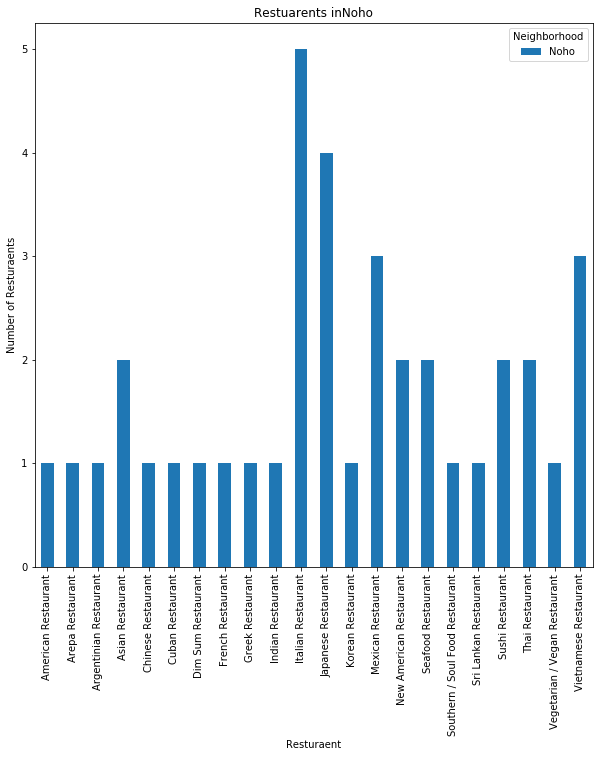

In [28]:
df_nb=df_nb.loc[:, (df_nb > 0).all()]
df_transpose = df_nb.transpose() 
df_transpose.plot(kind='bar', figsize=(10, 10))

plt.xlabel('Resturaent') # add to x-label to the plot
plt.ylabel('Number of Resturaents') # add y-label to the plot
plt.title('Restuarents inNoho') # add title to the plot

plt.show()

In [29]:
df_total = ny_venues.groupby('Venue Category').agg(['count'])
df_total2=ny_venues
df3=df_total2.groupby(['Venue Category']).size().reset_index(name='counts')
df3=df3[df3['Venue Category'].isin(ny_Restaurant)]
df3.reset_index(drop=True, inplace=True)
df3.set_index('Venue Category', inplace=True)
df4=df3.sort_values(['counts'], ascending=False)
df4.head(10)

counts
Venue Category                  
Italian Restaurant           103
American Restaurant           60
Mexican Restaurant            51
Chinese Restaurant            47
Sushi Restaurant              38
Japanese Restaurant           37
Seafood Restaurant            37
French Restaurant             34
Thai Restaurant               29
Mediterranean Restaurant      27

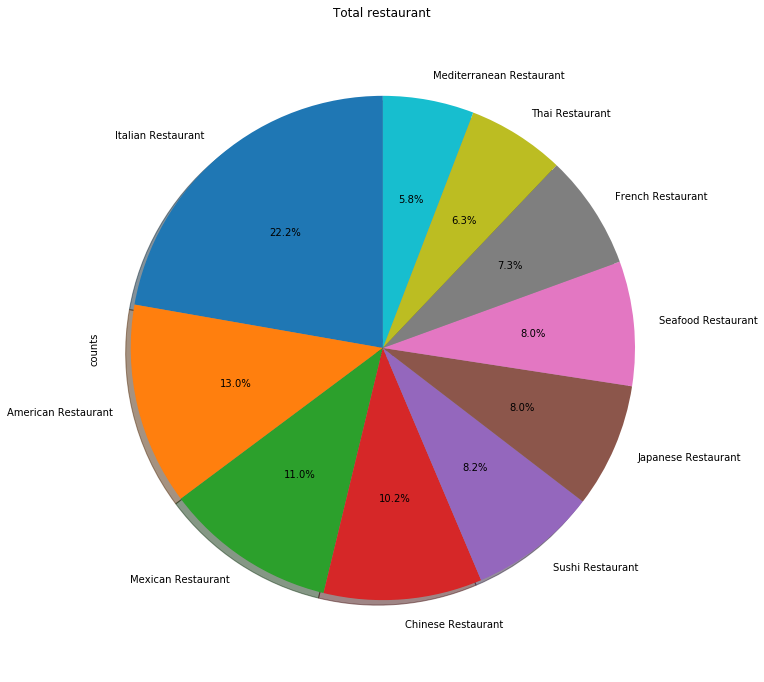

In [30]:
# autopct create %, start angle represent starting point
df4['counts'].head(10).plot(kind='pie',
                            figsize=(10, 12),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=True,       # add shadow      
                            )

plt.title('Total restaurant')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

In [31]:
#df_top15 = df4['counts'].head(15)
#df_top15

df5=df3.sort_values(by='counts', ascending=True, inplace=True)

# get top 15 countries
df_top15 = df3['counts'].tail(15)
df_top15

Venue Category
Vegetarian / Vegan Restaurant     18
Indian Restaurant                 18
New American Restaurant           19
Korean Restaurant                 19
Vietnamese Restaurant             21
Mediterranean Restaurant          27
Thai Restaurant                   29
French Restaurant                 34
Seafood Restaurant                37
Japanese Restaurant               37
Sushi Restaurant                  38
Chinese Restaurant                47
Mexican Restaurant                51
American Restaurant               60
Italian Restaurant               103
Name: counts, dtype: int64

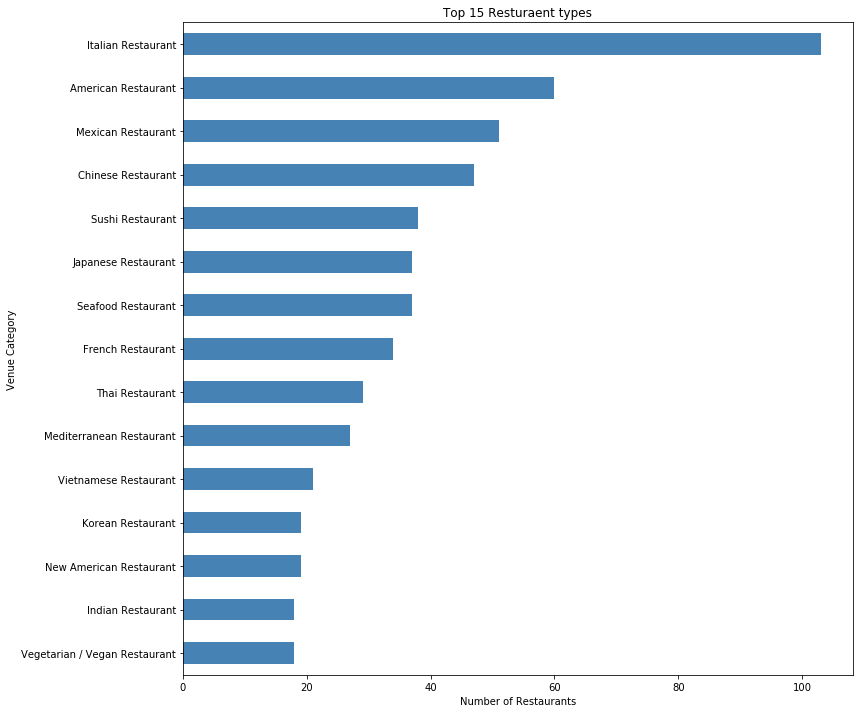

In [32]:
df_top15.plot(kind='barh', figsize=(12, 12), color='steelblue')
plt.xlabel('Number of Restaurants')
plt.title('Top 15 Resturaent types')

for index, value in enumerate(df_top15): 
    label = format(int(value), ',') # format int with commas
    
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value, index - 0.10), color='white')
plt.show()

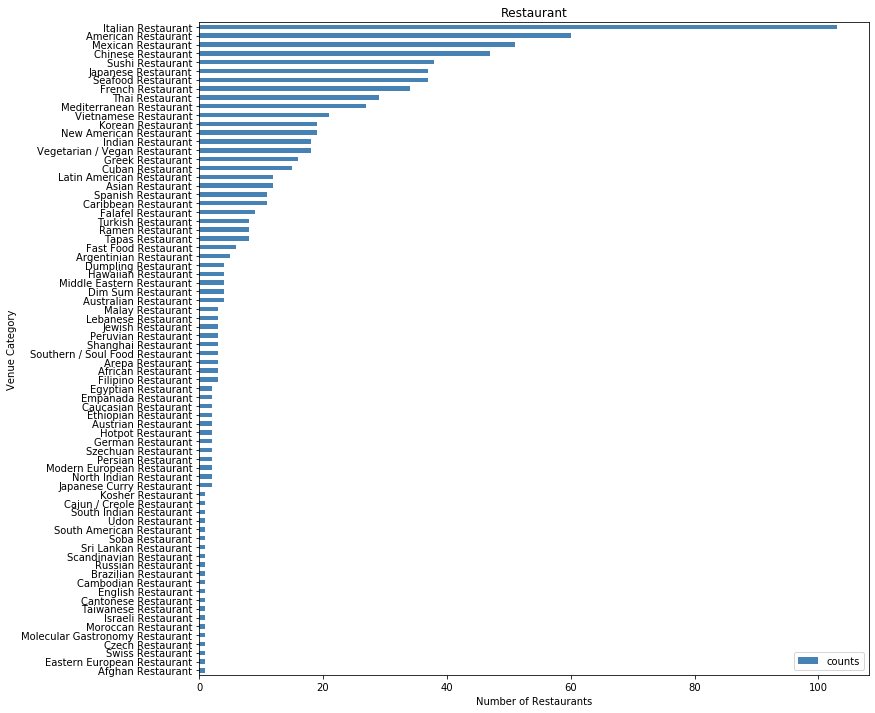

In [33]:
df3.plot(kind='barh', figsize=(12, 12), color='steelblue')
plt.xlabel('Number of Restaurants')
plt.title('Restaurant')

for index, value in enumerate(df_top15): 
    label = format(int(value), ',') # format int with commas
    
    # place text at the end of bar (subtracting 47000 from x, and 0.1 from y to make it fit within the bar)
    plt.annotate(label, xy=(value, index - 0.10), color='white')
plt.show()

In [35]:
!conda install -c conda-forge wordcloud==1.4.1 --yes

from wordcloud import WordCloud, STOPWORDS

Solving environment: done

# All requested packages already installed.



In [36]:
# open the file and read it into a variable alice_novel
L1=ny_venues['Venue Category']
L2=L1[L1.isin(ny_Restaurant)]
alice_novel = " ,".join(L2)
alice_novel.replace('Restaurant', '')
alice_novel

'Seafood Restaurant ,American Restaurant ,Greek Restaurant ,English Restaurant ,Hotpot Restaurant ,New American Restaurant ,Spanish Restaurant ,Chinese Restaurant ,Chinese Restaurant ,Chinese Restaurant ,American Restaurant ,Asian Restaurant ,Thai Restaurant ,Asian Restaurant ,Greek Restaurant ,American Restaurant ,American Restaurant ,Malay Restaurant ,Malay Restaurant ,Vietnamese Restaurant ,Dim Sum Restaurant ,Chinese Restaurant ,Vietnamese Restaurant ,Chinese Restaurant ,Italian Restaurant ,Dumpling Restaurant ,Mexican Restaurant ,Mexican Restaurant ,Austrian Restaurant ,Shanghai Restaurant ,Vegetarian / Vegan Restaurant ,Taiwanese Restaurant ,Vietnamese Restaurant ,Cantonese Restaurant ,Chinese Restaurant ,Dim Sum Restaurant ,Australian Restaurant ,Dumpling Restaurant ,Chinese Restaurant ,Chinese Restaurant ,Seafood Restaurant ,Empanada Restaurant ,Italian Restaurant ,Ramen Restaurant ,American Restaurant ,Tapas Restaurant ,New American Restaurant ,Caribbean Restaurant ,Indian Res

In [37]:
# instantiate a word cloud object
alice_wc = WordCloud(
    background_color='white',
    max_words=2000,
)

# generate the word cloud
alice_wc.generate(alice_novel)

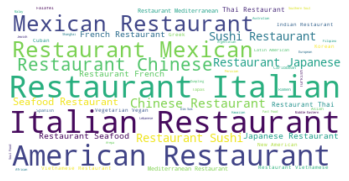

In [38]:

plt.imshow(alice_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [39]:
df_can=  pd.DataFrame(index=df_ny_Restaurant_grouped2.index)
df_can['Total'] = df_ny_Restaurant_grouped2.sum(axis=1)
df_can.head()

Total
Neighborhood            
Battery Park City      4
Carnegie Hill         17
Central Harlem        15
Chelsea               12
Chinatown             40

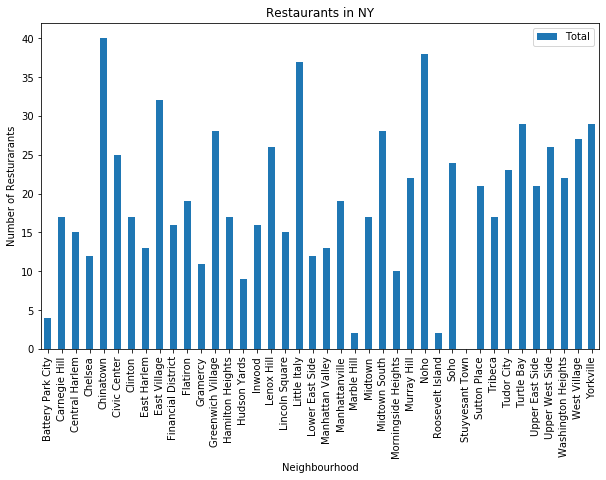

In [40]:
df_can.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Number of Resturarants') # add y-label to the plot
plt.title('Restaurants in NY') # add title to the plot

plt.show()

In [41]:
df_ny_res_group=df_ny_Restaurant_grouped2
df_ny_res_group.head()

Afghan Restaurant  African Restaurant  American Restaurant  \
Neighborhood                                                                    
Battery Park City                  0                   0                    0   
Carnegie Hill                      0                   0                    1   
Central Harlem                     0                   3                    2   
Chelsea                            0                   0                    3   
Chinatown                          0                   0                    3   

                   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
Neighborhood                                                                    
Battery Park City                 0                       0                 0   
Carnegie Hill                     0                       1                 0   
Central Harlem                    0                       0                 0   
Chelsea                           0                       0                 0   
Chinatown                         0                       0                 2   

                   Australian Restaurant  Austrian Restaurant  \
Neighborhood                                                    
Battery Park City                      0                    0   
Carnegie Hill                          0                    0   
Central Harlem                         0                    0   
Chelsea                                0                    0   
Chinatown                              1                    1   

                   Brazilian Restaurant  Cajun / Creole Restaurant  \
Neighborhood                                                         
Battery Park City                     0                          0   
Carnegie Hill                         0                          0   
Central Harlem                        0                          0   
Chelsea                               0                          0   
Chinatown                             0                          0   

                   Cambodian Restaurant  Cantonese Restaurant  \
Neighborhood                                                    
Battery Park City                     0                     0   
Carnegie Hill                         0                     0   
Central Harlem                        0                     0   
Chelsea                               0                     0   
Chinatown                             0                     1   

                   Caribbean Restaurant  Caucasian Restaurant  \
Neighborhood                                                    
Battery Park City                     0                     0   
Carnegie Hill                         0                     0   
Central Harlem                        1                     0   
Chelsea                               0                     0   
Chinatown                             0                     0   

                   Chinese Restaurant  Cuban Restaurant  Czech Restaurant  \
Neighborhood                                                                
Battery Park City                   1                 0                 0   
Carnegie Hill                       0                 0                 0   
Central Harlem                      2                 0                 0   
Chelsea                             1                 0                 0   
Chinatown                           8                 0                 0   

                   Dim Sum Restaurant  Dumpling Restaurant  \
Neighborhood                                                 
Battery Park City                   0                    0   
Carnegie Hill                       0                    0   
Central Harlem                      0                    0   
Chelsea                             0                    0   
Chinatown                           2                    2   

                   Eastern European Restaurant  E

In [44]:
#df_ny_res_group.reset_index()
Neighborhood = df_ny_res_group.index
#df_ny_res_group.drop(labels=['Neighborhood'], axis=1,inplace = True)
#df_ny_res_group.insert(0, 'Neighborhood', Neighborhood)
#df_ny_res_group['Neighborhood'] = df_ny_res_group.index
#df_ny_res_group.reset_index()
df_ny_res_group.head()

Neighborhood  Afghan Restaurant  African Restaurant  \
Neighborhood                                                                  
Battery Park City  Battery Park City                  0                   0   
Carnegie Hill          Carnegie Hill                  0                   0   
Central Harlem        Central Harlem                  0                   3   
Chelsea                      Chelsea                  0                   0   
Chinatown                  Chinatown                  0                   0   

                   American Restaurant  Arepa Restaurant  \
Neighborhood                                               
Battery Park City                    0                 0   
Carnegie Hill                        1                 0   
Central Harlem                       2                 0   
Chelsea                              3                 0   
Chinatown                            3                 0   

                   Argentinian Restaurant  Asian Restaurant  \
Neighborhood                                                  
Battery Park City                       0                 0   
Carnegie Hill                           1                 0   
Central Harlem                          0                 0   
Chelsea                                 0                 0   
Chinatown                               0                 2   

                   Australian Restaurant  Austrian Restaurant  \
Neighborhood                                                    
Battery Park City                      0                    0   
Carnegie Hill                          0                    0   
Central Harlem                         0                    0   
Chelsea                                0                    0   
Chinatown                              1                    1   

                   Brazilian Restaurant  Cajun / Creole Restaurant  \
Neighborhood                                                         
Battery Park City                     0                          0   
Carnegie Hill                         0                          0   
Central Harlem                        0                          0   
Chelsea                               0                          0   
Chinatown                             0                          0   

                   Cambodian Restaurant  Cantonese Restaurant  \
Neighborhood                                                    
Battery Park City                     0                     0   
Carnegie Hill                         0                     0   
Central Harlem                        0                     0   
Chelsea                               0                     0   
Chinatown                             0                     1   

                   Caribbean Restaurant  Caucasian Restaurant  \
Neighborhood                                                    
Battery Park City                     0                     0   
Carnegie Hill                         0                     0   
Central Harlem                        1                     0   
Chelsea                               0                     0   
Chinatown                             0                     0   

                   Chinese Restaurant  Cuban Restaurant  Czech Restaurant  \
Neighborhood                                                                
Battery Park City                   1                 0                 0   
Carnegie Hill                       0                 0                 0   
Central Harlem                      2                 0                 0   
Chelsea                             1                 0                 0   
Chinatown                           8                 0                 0   

                   Dim Sum Restaurant  Dumpling Restaurant  \
Neighborhood                                                 
Battery Park City                   0                    0   
Carnegie Hill         

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
df_neighborhoods_venues_sorted['Neighborhood'] = df_ny_Restaurant_grouped2['Neighborhood']

for ind in np.arange(df_ny_Restaurant_grouped2.shape[0]):
    df_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_ny_Restaurant_grouped2.iloc[ind, :], num_top_venues)

df_neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
Neighborhood                                                 
Battery Park City  Battery Park City    Mexican Restaurant   
Carnegie Hill          Carnegie Hill   Japanese Restaurant   
Central Harlem        Central Harlem    African Restaurant   
Chelsea                      Chelsea   American Restaurant   
Chinatown                  Chinatown    Chinese Restaurant   

                   2nd Most Common Venue     3rd Most Common Venue  \
Neighborhood                                                         
Battery Park City     Chinese Restaurant  Mediterranean Restaurant   
Carnegie Hill         Italian Restaurant         French Restaurant   
Central Harlem       American Restaurant        Chinese Restaurant   
Chelsea               Italian Restaurant        Seafood Restaurant   
Chinatown          Vietnamese Restaurant       American Restaurant   

                      4th Most Common Venue 5th Most Common Venue  \
Neighborhood                                                        
Battery Park City         French Restaurant   Empanada Restaurant   
Carnegie Hill         Vietnamese Restaurant       Thai Restaurant   
Central Harlem           Seafood Restaurant     French Restaurant   
Chelsea            Mediterranean Restaurant      Ramen Restaurant   
Chinatown                  Greek Restaurant      Malay Restaurant   

                    6th Most Common Venue 7th Most Common Venue  \
Neighborhood                                                      
Battery Park City      English Restaurant  Ethiopian Restaurant   
Carnegie Hill      Argentinian Restaurant    Mexican Restaurant   
Central Harlem           Tapas Restaurant  Ethiopian Restaurant   
Chelsea                Chinese Restaurant     French Restaurant   
Chinatown             Dumpling Restaurant      Asian Restaurant   

                  8th Most Common Venue            9th Most Common Venue  \
Neighborhood                                                               
Battery Park City    Falafel Restaurant             Fast Food Restaurant   
Carnegie Hill      Fast Food Restaurant    Vegetarian / Vegan Restaurant   
Central Harlem     Caribbean Restaurant  Southern / Soul Food Restaurant   
Chelsea                Sushi Restaurant               Falafel Restaurant   
Chinatown            Dim Sum Restaurant               Mexican Restaurant   

                  10th Most Common Venue  
Neighborhood                              
Battery Park City    Filipino Restaurant  
Carnegie Hill          Kosher Restaurant  
Central Harlem     Vietnamese Restaurant  
Chelsea              Empanada Restaurant  
Chinatown           Cantonese Restaurant

In [47]:
# set number of clusters
kclusters = 5

df_ny_grouped_clustering = df_ny_Restaurant_grouped2.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 2, 4, 2, 2, 0, 0, 2], dtype=int32)

In [54]:
# add clustering labels
df_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_ny_merged = ny_venues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_ny_merged = df_ny_merged.join(df_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

df_ny_merged.head() # check the last columns!

ValueError: cannot insert Cluster Labels, already exists

In [49]:
df_ny_merged["Cluster Labels"] = pd.to_numeric(df_ny_merged["Cluster Labels"])

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]

colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_ny_merged['Venue Latitude'], df_ny_merged['Venue Longitude'], df_ny_merged['Neighborhood'], df_ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [56]:
df2=df_ny_merged.loc[df_ny_merged['Cluster Labels'] == 4,]
df2.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
26    Chinatown              40.715618              -73.994279   
27    Chinatown              40.715618              -73.994279   
28    Chinatown              40.715618              -73.994279   
29    Chinatown              40.715618              -73.994279   
30    Chinatown              40.715618              -73.994279   

                  Venue  Venue Latitude  Venue Longitude    Venue Category  \
26    Cheeky Sandwiches       40.715821       -73.991830    Sandwich Place   
27               Kiki's       40.714476       -73.992036  Greek Restaurant   
28  Hotel 50 Bowery NYC       40.715936       -73.996789             Hotel   
29        Renew Day Spa       40.715559       -73.996747               Spa   
30      Michaeli Bakery       40.714704       -73.991847            Bakery   

    Cluster Labels 1st Most Common Venue  2nd Most Common Venue  \
26               4    Chinese Restaurant  Vietnamese Restaurant   
27               4    Chinese Restaurant  Vietnamese Restaurant   
28               4    Chinese Restaurant  Vietnamese Restaurant   
29               4    Chinese Restaurant  Vietnamese Restaurant   
30               4    Chinese Restaurant  Vietnamese Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
26   American Restaurant      Greek Restaurant      Malay Restaurant   
27   American Restaurant      Greek Restaurant      Malay Restaurant   
28   American Restaurant      Greek Restaurant      Malay Restaurant   
29   American Restaurant      Greek Restaurant      Malay Restaurant   
30   American Restaurant      Greek Restaurant      Malay Restaurant   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
26   Dumpling Restaurant      Asian Restaurant    Dim Sum Restaurant   
27   Dumpling Restaurant      Asian Restaurant    Dim Sum Restaurant   
28   Dumpling Restaurant      Asian Restaurant    Dim Sum Restaurant   
29   Dumpling Restaurant      Asian Restaurant    Dim Sum Restaurant   
30   Dumpling Restaurant      Asian Restaurant    Dim Sum Restaurant   

   9th Most Common Venue 10th Most Common Venue  
26    Mexican Restaurant   Cantonese Restaurant  
27    Mexican Restaurant   Cantonese Restaurant  
28    Mexican Restaurant   Cantonese Restaurant  
29    Mexican Restaurant   Cantonese Restaurant  
30    Mexican Restaurant   Cantonese Restaurant

In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df2['Venue Latitude'], df2['Venue Longitude'], df2['Neighborhood'], df2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [58]:
df2=df_ny_merged.loc[df_ny_merged['Cluster Labels'] == 0,]
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df2['Venue Latitude'], df2['Venue Longitude'], df2['Neighborhood'], df2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Conclusion <a name="conclusion"></a>

In this study, I analyzed the restaurants and neighborhoods and come to conclusion that Italian restaurant is the most common restaurant in  all neighborhood. We also find out the 10 most common restaurant cuisines in all neighborhood. So from this data we can predict the new cuisines to be add to a restaurant menu. 